# Accelerating Cleantech Advancements through NLP-Powered Text Mining and Knowledge Extraction
### Notebook 5: Building & Training Word2Vec Model

Author: Andrea V.


# 1. Import Packages and Global Variables

In [ ]:
# # Install the 'Torchtext' library
%%capture
!pip install torch torchtext torchdata

In [ ]:
# # Install the 'gensim' library
%%capture
!pip install gensim

In [21]:
# Import necessary libraries

from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import string

import math
import copy
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
# For creating own Word2Vec embeddings

import os
import random
import re
from collections import Counter, OrderedDict
from dataclasses import dataclass
from time import monotonic
from typing import Dict, List, Optional, Union

import numpy as np
import torch
import torch.nn as nn
from scipy.spatial.distance import cosine
from torch.utils.data import DataLoader
from torchtext.data import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from tqdm import tqdm


In [72]:
# For creating own Doc2vec embeddings

from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
from nltk import sent_tokenize

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# 2. Import data

In [24]:
#Read csv file
file_path = Path("/cleantech_media_dataset_v1_20231109.csv") 

df = pd.read_csv(file_path)

In [25]:
# Display the first few rows of the DataFrame
df.head()

,Unnamed: 0,title,date,author,content,domain,url
0,1280,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,"[""Qatar Petroleum ( QP) is targeting aggressiv...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
1,1281,India Launches Its First 700 MW PHWR,2021-01-15,NaN,"[""• Nuclear Power Corp. of India Ltd. ( NPCIL)...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
2,1283,New Chapter for US-China Energy Trade,2021-01-20,NaN,"[""New US President Joe Biden took office this ...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
3,1284,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,"[""The slow pace of Japanese reactor restarts c...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
4,1285,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,"[""Two of New York City's largest pension funds...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...


In [ ]:
docsA= df['content']

# 3. Building, Training and Comparing Word2Vec Embedding Models


### 3.1 Data Preparation for Embedings

In the below section the text data has been preprocessed for training embeddings, ensuring it was clean and well-structured. The data was then split into training and validation sets to assess model performance.


In [ ]:
# second version for removing stopwords as well in preprocessing
# Set seeds for reproducibility
SEED = 25
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Set stopwords list
stop_words = set(stopwords.words('english'))

# Function to remove non-alphanumeric characters and stopwords
def preprocess_text(text):
    # Remove non-alphanumeric characters
    alphanumeric_text = ''.join(char for char in text if char.isalnum() or char.isspace())

    # Remove stopwords
    filtered_text = ' '.join(word for word in alphanumeric_text.split() if word.lower() not in stop_words)

    return filtered_text

# Function to convert dataset to map-style dataset
def to_map_style_dataset(dataset):
    return [preprocess_text(text) for text in dataset]

def get_data(test_size=0.2, random_state=25):
    # Split the DataFrame into train and test
    train_df, valid_df = train_test_split(docsA, test_size=test_size, random_state=random_state)

    # Convert the data to map-style datasets
    train_iter = to_map_style_dataset(train_df)
    valid_iter = to_map_style_dataset(valid_df)

    return train_iter, valid_iter

# Call get_data without passing the DataFrame
train_iter, valid_iter = get_data()

# Example of printing the first 6 elements from the train_iter
count = 0
for text in iter(train_iter):
    print(text)
    count += 1
    if count == 6:
        break

Energy storage grown significantly last ten years particularly Tesla Powerwall Powerpack Megapack battery systems latter unusual edition Cleantech Leader Laggard Week week got country highlight exactly breaking past present future charging market United States impacts rate adoption electric vehicles matter way cut Inflation Reduction Act Bipartisan Infrastructure Law stimulating massive reinvestment manufacturing infrastructure Swedish technology logistics company envisions AIenhanced allelectric digital cargo transportation ecosystem save customers time money curtailing CleanTechnica 1 cleantechfocused news analysis website US world focusing primarily electric cars solar energy wind energy energy storage News published CleanTechnicacom reports published futureCleanTechnicacomreports Tesla Model 3 crosscountry road trip statebystate breakdown Utah 99 miles Wyoming 450 miles South Dakota 450 miles Minnesota 250 miles Wisconsin 240 comes electric vehicles many people likely assume LED he

### 3.2 Implementing Word2Vec in Pytorch

In the following section, we've constructed a custom Word2Vec model from scratch, building upon the foundation of the source article with specific adaptations. These modifications were essential to facilitate experimentation and comparison of models with varying parameter settings. The model allows us to store essential comparison metrics, including the word sample list and word embedding vectors. Additionally, we examine the five most similar words, along with their calculated cosine similarity values, for four example words.

Source: https://towardsdatascience.com/implementing-word2vec-in-pytorch-from-the-ground-up-c7fe5bf99889


In [ ]:
# setting parameters and configuration of our model

@dataclass(repr=True, unsafe_hash=True)
class Word2VecParams:

    # skipgram parameters
    MIN_FREQ = 50             #concidering words which occur minimum 50 times
    SKIPGRAM_N_WORDS = 4      #windowsize for skipgrams (look at 8 words before and after the target word)
    T = 85                    # subsampling probability (85th percentile)
    NEG_SAMPLES = 50          #number of negative samples
    NS_ARRAY_LEN = 5_000_000  #length of the negative sampling vector that we will sample negative observations from
    SPECIALS = ""             # placeholder for excluded words if they do not meet the min frequency
    TOKENIZER = 'basic_english'

    # network parameters
    BATCH_SIZE = 50          # number of documents that will be in each minibatch used to train the network
    EMBED_DIM = 250           # dimensionality of the embeddings
    EMBED_MAX_NORM = None
    N_EPOCHS = 5
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    CRITERION = nn.BCEWithLogitsLoss()

    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [ ]:
params = Word2VecParams()

In [ ]:
# building the vocabulary

class Vocab:
    def __init__(self, list, specials):
        self.stoi = {v[0]:(k, v[1]) for k, v in enumerate(list)}
        self.itos = {k:(v[0], v[1]) for k, v in enumerate(list)}
        self._specials = specials[0]
        self.total_tokens = np.nansum(
            [f for _, (_, f) in self.stoi.items()]
            , dtype=int)

    def __len__(self):
        return len(self.stoi) - 1

    def get_index(self, word: Union[str, List]):
        if isinstance(word, str):
            if word in self.stoi:
                return self.stoi.get(word)[0]
            else:
                return self.stoi.get(self._specials)[0]
        elif isinstance(word, list):
            res = []
            for w in word:
                if w in self.stoi:
                    res.append(self.stoi.get(w)[0])
                else:
                    res.append(self.stoi.get(self._specials)[0])
            return res
        else:
            raise ValueError(
                f"Word {word} is not a string or a list of strings."
                )


    def get_freq(self, word: Union[str, List]):
        if isinstance(word, str):
            if word in self.stoi:
                return self.stoi.get(word)[1]
            else:
                return self.stoi.get(self._specials)[1]
        elif isinstance(word, list):
            res = []
            for w in word:
                if w in self.stoi:
                    res.append(self.stoi.get(w)[1])
                else:
                    res.append(self.stoi.get(self._specials)[1])
            return res
        else:
            raise ValueError(
                f"Word {word} is not a string or a list of strings."
                )


    def lookup_token(self, token: Union[int, List]):
        if isinstance(token, (int, np.int64)):
            if token in self.itos:
                return self.itos.get(token)[0]
            else:
                raise ValueError(f"Token {token} not in vocabulary")
        elif isinstance(token, list):
            res = []
            for t in token:
                if t in self.itos:
                    res.append(self.itos.get(token)[0])
                else:
                    raise ValueError(f"Token {t} is not a valid index.")
            return res


The above functions help the below:

*   Lookup word in vocabulary by name: vocab.stoi.get('')
*   Lookup word in vocabulary by index: vocab.itos.get(integer)
*   Lookup word index value in vocabulary by name: vocab.get_index('')
*   Lookup word frequency in vocabulary by name: vocab.get_freq('')
*   Lookup word in vocabulary index value: vocab.lookup_token(integer)
*   Lookup number of total tokens in the corpus: vocab.total_tokens



In [ ]:
# yield_tokens() preprocesses and tokenizes the text. The preprocessing simply removes all characters that are not letters or digits

def yield_tokens(iterator, tokenizer):
    r = re.compile('[a-z1-9]')
    for text in iterator:
        res = tokenizer(text)
        res = list(filter(r.match, res))
        yield res

# build_vocab()function takes the raw text, tokenizes it, and then constructs a Vocab object.

def build_vocab(
        iterator,
        tokenizer,
        params: Word2VecParams,
        max_tokens: Optional[int] = None,
    ):
    counter = Counter()
    for tokens in yield_tokens(iterator, tokenizer):
        counter.update(tokens)

    # First sort by descending frequency, then lexicographically
    sorted_by_freq_tuples = sorted(
        counter.items(), key=lambda x: (-x[1], x[0])
        )

    ordered_dict = OrderedDict(sorted_by_freq_tuples)

    tokens = []
    for token, freq in ordered_dict.items():
        if freq >= params.MIN_FREQ:
            tokens.append((token, freq))

    specials = (params.SPECIALS, np.nan)
    tokens[0] = specials

    return Vocab(tokens, specials)


In [ ]:
# Builing the pytorch data loaders:

class SkipGrams:
    def __init__(self, vocab: Vocab, params: Word2VecParams, tokenizer):
        self.vocab = vocab
        self.params = params
        self.t = self._t()
        self.tokenizer = tokenizer
        self.discard_probs = self._create_discard_dict()

    # setting the probability of randomly sampling a word with a frequency in the 85th percentile or above
    def _t(self):
        freq_list = []
        for _, (_, freq) in list(self.vocab.stoi.items())[1:]:
            freq_list.append(freq/self.vocab.total_tokens)
        return np.percentile(freq_list, self.params.T)

    # creates a python dictionary where the key is a word index and the value is the probability of discarding it
    def _create_discard_dict(self):
        discard_dict = {}
        for _, (word, freq) in self.vocab.stoi.items():
            dicard_prob = 1-np.sqrt(
                self.t / (freq/self.vocab.total_tokens + self.t))
            discard_dict[word] = dicard_prob
        return discard_dict


    def collate_skipgram(self, batch):
        batch_input, batch_output  = [], []

        # loop over every text in the batch and convert all the tokens to the corresponding vocabulary index:
        for text in batch:
            text_tokens = self.vocab.get_index(self.tokenizer(text))

            #checking wether the text is sufficiently long to generate training example
            if len(text_tokens) < self.params.SKIPGRAM_N_WORDS * 2 + 1:
                continue

            # creating a list of the target word and a list of all the context words
            for idx in range(len(text_tokens) - self.params.SKIPGRAM_N_WORDS*2
                ):
                token_id_sequence = text_tokens[
                    idx : (idx + self.params.SKIPGRAM_N_WORDS * 2 + 1)
                    ]
                input_ = token_id_sequence.pop(self.params.SKIPGRAM_N_WORDS)
                outputs = token_id_sequence

                # implementing subsampling of the target word
                prb = random.random()
                del_pair = self.discard_probs.get(input_)
                if input_==0 or del_pair >= prb:
                    continue
                # execute the same subsampling procedure for the context words if the previous step did not remove the target word itself
                else:
                    for output in outputs:
                        prb = random.random()
                        del_pair = self.discard_probs.get(output)
                        if output==0 or del_pair >= prb:
                            continue
                        else:
                            batch_input.append(input_)
                            batch_output.append(output)

        # batch_input list will have the indices for each target word
        batch_input = torch.tensor(batch_input, dtype=torch.long)

        # batch_output list will contain positive context word indices for each target word
        batch_output = torch.tensor(batch_output, dtype=torch.long)

        return batch_input, batch_output


In [ ]:
# creating the negative sampling array

class NegativeSampler:
    def __init__(self, vocab: Vocab, ns_exponent: float, ns_array_len: int):
        self.vocab = vocab
        self.ns_exponent = ns_exponent
        self.ns_array_len = ns_array_len
        self.ns_array = self._create_negative_sampling()

    def __len__(self):
        return len(self.ns_array)

    def _create_negative_sampling(self):

        frequency_dict = {word:freq**(self.ns_exponent) \
                          for _,(word, freq) in
                          list(self.vocab.stoi.items())[1:]}
        frequency_dict_scaled = {
            word:
            max(1,int((freq/self.vocab.total_tokens)*self.ns_array_len))
            for word, freq in frequency_dict.items()
            }
        ns_array = []
        for word, freq in tqdm(frequency_dict_scaled.items()):
            ns_array = ns_array + [word]*freq
        return ns_array

    def sample(self,n_batches: int=1, n_samples: int=1):
        samples = []
        for _ in range(n_batches):
            samples.append(random.sample(self.ns_array, n_samples))
        samples = torch.as_tensor(np.array(samples))
        return samples

In [ ]:
 # building the word2vec model in PyTorch

class Model(nn.Module):
    def __init__(self, vocab: Vocab, params: Word2VecParams):
        super().__init__()
        self.vocab = vocab
        self.t_embeddings = nn.Embedding(
            self.vocab.__len__()+1,
            params.EMBED_DIM,
            max_norm=params.EMBED_MAX_NORM
            )
        self.c_embeddings = nn.Embedding(
            self.vocab.__len__()+1,
            params.EMBED_DIM,
            max_norm=params.EMBED_MAX_NORM
            )

    # passing data through the network
    def forward(self, inputs, context):
        target_embeddings = self.t_embeddings(inputs)
        n_examples = target_embeddings.shape[0]
        n_dimensions = target_embeddings.shape[1]
        target_embeddings = target_embeddings.view(n_examples, 1, n_dimensions)

        context_embeddings = self.c_embeddings(context)
        context_embeddings = context_embeddings.permute(0,2,1)

        dots = target_embeddings.bmm(context_embeddings)
        dots = dots.view(dots.shape[0], dots.shape[2])
        return dots

    # creates a lookup table of word vectors
    def normalize_embeddings(self):
        embeddings = list(self.t_embeddings.parameters())[0]
        embeddings = embeddings.cpu().detach().numpy()
        norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
        norms = norms.reshape(norms.shape[0], 1)
        return embeddings / norms

    # takes a word and will return a list of the top-n most similar words (used cosine similarity)
    def get_similar_words(self, word, n):
        word_id = self.vocab.get_index(word)
        if word_id == 0:
            print("Out of vocabulary word")
            return

        embedding_norms = self.normalize_embeddings()
        word_vec = embedding_norms[word_id]
        word_vec = np.reshape(word_vec, (word_vec.shape[0], 1))
        dists = np.matmul(embedding_norms, word_vec).flatten()
        topN_ids = np.argsort(-dists)[1 : n + 1]

        topN_dict = {}
        for sim_word_id in topN_ids:
            sim_word = self.vocab.lookup_token(sim_word_id)
            topN_dict[sim_word] = dists[sim_word_id]
        return topN_dict

    # takes two words and will return the cosine similarity between the two word vectors.
    def get_similarity(self, word1, word2):
        idx1 = self.vocab.get_index(word1)
        idx2 = self.vocab.get_index(word2)
        if idx1 == 0 or idx2 == 0:
            print("One or both words are out of vocabulary")
            return

        embedding_norms = self.normalize_embeddings()
        word1_vec, word2_vec = embedding_norms[idx1], embedding_norms[idx2]

        return cosine(word1_vec, word2_vec)


In [ ]:
# creating the Trainer

class Trainer:
    def __init__(self, model: Model, params: Word2VecParams, optimizer,
                vocab: Vocab, train_iter, valid_iter, skipgrams: SkipGrams):
        self.model = model
        self.optimizer = optimizer
        self.vocab = vocab
        self.train_iter = train_iter
        self.valid_iter = valid_iter
        self.skipgrams = skipgrams
        self.params = params

        self.epoch_train_mins = {}
        self.loss = {"train": [], "valid": []}

        # sending all to device
        self.model.to(self.params.DEVICE)
        self.params.CRITERION.to(self.params.DEVICE)

        self.negative_sampler = NegativeSampler(
            vocab=self.vocab, ns_exponent=.75,
            ns_array_len=self.params.NS_ARRAY_LEN
            )
        self.testwords = ['agriculture', 'energies', 'solar', 'project']
        self.similar_words_results = {}  # Initialize similar_words_results


    # function to start the start the model training
    def train(self):
        for epoch in range(self.params.N_EPOCHS):
            # Generate Dataloaders
            self.train_dataloader = DataLoader(
                self.train_iter,
                batch_size=self.params.BATCH_SIZE,
                shuffle=False,
                collate_fn=self.skipgrams.collate_skipgram
            )
            self.valid_dataloader = DataLoader(
                self.valid_iter,
                batch_size=self.params.BATCH_SIZE,
                shuffle=False,
                collate_fn=self.skipgrams.collate_skipgram
            )
            # training the model
            st_time = monotonic()
            self._train_epoch()
            self.epoch_train_mins[epoch] = round((monotonic()-st_time)/60, 1)

            # validating the model
            self._validate_epoch()
            print(f"""Epoch: {epoch+1}/{self.params.N_EPOCHS}\n""",
            f"""    Train Loss: {self.loss['train'][-1]:.2}\n""",
            f"""    Valid Loss: {self.loss['valid'][-1]:.2}\n""",
            f"""    Training Time (mins): {self.epoch_train_mins.get(epoch)}"""
            """\n"""
            )
            self.test_testwords()


    def _train_epoch(self):
        self.model.train()
        running_loss = []

        for i, batch_data in enumerate(self.train_dataloader, 1):
            if len(batch_data[0]) == 0:
                continue
            inputs = batch_data[0].to(self.params.DEVICE)
            pos_labels = batch_data[1].to(self.params.DEVICE)
            neg_labels = self.negative_sampler.sample(
                pos_labels.shape[0], self.params.NEG_SAMPLES
                )
            neg_labels = neg_labels.to(self.params.DEVICE)
            context = torch.cat(
                [pos_labels.view(pos_labels.shape[0], 1),
                neg_labels], dim=1
              )

            # building the targets tensor
            y_pos = torch.ones((pos_labels.shape[0], 1))
            y_neg = torch.zeros((neg_labels.shape[0], neg_labels.shape[1]))
            y = torch.cat([y_pos, y_neg], dim=1).to(self.params.DEVICE)

            self.optimizer.zero_grad()

            outputs = self.model(inputs, context)
            loss = self.params.CRITERION(outputs, y)
            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())

        epoch_loss = np.mean(running_loss)

        self.loss['train'].append(epoch_loss)

    def _validate_epoch(self):
        self.model.eval()
        running_loss = []

        with torch.no_grad():
            for i, batch_data in enumerate(self.valid_dataloader, 1):
                if len(batch_data[0]) == 0:
                    continue
                inputs = batch_data[0].to(self.params.DEVICE)
                pos_labels = batch_data[1].to(self.params.DEVICE)
                neg_labels = self.negative_sampler.sample(
                    pos_labels.shape[0], self.params.NEG_SAMPLES
                    ).to(self.params.DEVICE)
                context = torch.cat(
                    [pos_labels.view(pos_labels.shape[0], 1),
                    neg_labels], dim=1
                  )


                # building the targets tensor
                y_pos = torch.ones((pos_labels.shape[0], 1))
                y_neg = torch.zeros((neg_labels.shape[0], neg_labels.shape[1]))
                y = torch.cat([y_pos, y_neg], dim=1).to(self.params.DEVICE)

                preds = self.model(inputs, context).to(self.params.DEVICE)
                loss = self.params.CRITERION(preds, y)

                running_loss.append(loss.item())

            epoch_loss = np.mean(running_loss)
            self.loss['valid'].append(epoch_loss)

    def test_testwords(self, n: int = 5):
        for word in self.testwords:
            print(word)
            nn_words = self.model.get_similar_words(word, n)
            similar_words_for_word = {}
            for w, sim in nn_words.items():
                print(f"{w} ({sim:.3})", end=' ')
                similar_words_for_word[w] = sim
            print('\n')
            self.similar_words_results[word] = similar_words_for_word  # Save similar words for the word

        return self.similar_words_results  # Return the results



### 3.3 Evaluation In-house Word2Vec Models

We've developed a function to compare Word2Vec models trained with different parameters. This function takes the modified parameters as input, initializes and trains the model, and then returns the trained model along with related information. This streamlined approach enhances the efficiency of comparing models with varying configurations.

In [ ]:
# creating a function that takes parameters as input, initializes the model, trains it, and returns the name of the model, similar words and cosine similarity, words vocabulary and embeddings

def train_word2vec_model(params, variant_name):
    train_iter, valid_iter = get_data()
    tokenizer = get_tokenizer(params.TOKENIZER)
    vocab = build_vocab(train_iter, tokenizer, params)
    skip_gram = SkipGrams(vocab=vocab, params=params, tokenizer=tokenizer)
    model = Model(vocab=vocab, params=params).to(params.DEVICE)
    optimizer = torch.optim.Adam(params=model.parameters())

    trainer = Trainer(
        model=model,
        params=params,
        optimizer=optimizer,
        train_iter=train_iter,
        valid_iter=valid_iter,
        vocab=vocab,
        skipgrams=skip_gram
    )
    trainer.train()

    def test_testwords():
        similar_words_result = trainer.test_testwords()
        return similar_words_result

    # 1. Get the 5 most similar testwords
    similar_words_results = test_testwords()

    # 2. Get the words from the vocabulary sample
    vocab_sample = list(vocab.stoi.keys())[:]  #getting all vocabulary

    # 3. Get the embeddings of word forms
    word_embeddings = model.normalize_embeddings()


    return {
        'variant_name': variant_name,
        'similar_words': similar_words_results,
        'vocab_sample': vocab_sample,
        'word_embeddings': word_embeddings
    }

In [ ]:
# creating the parameter changes for different training scenarios

base_params = {
    'MIN_FREQ': 50,
    'SKIPGRAM_N_WORDS': 4,
    'T': 85,
    'NEG_SAMPLES': 50,
    'NS_ARRAY_LEN': 5_000_000,
    'SPECIALS': "",
    'TOKENIZER': 'basic_english',
    'BATCH_SIZE': 50,
    'EMBED_DIM': 300,
    'EMBED_MAX_NORM': None,
    'N_EPOCHS': 1,
    'DEVICE': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'CRITERION': nn.BCEWithLogitsLoss(),
}

# Scenario 2: Change SKIPGRAM_N_WORDS
scenario2_params = base_params.copy()
scenario2_params['SKIPGRAM_N_WORDS'] = 6

# Scenario 3: Change MIN_FREQ
scenario3_params = base_params.copy()
scenario3_params['MIN_FREQ'] = 100

# Scenario 4: Change N_EPOCHS
scenario4_params = base_params.copy()
scenario4_params['N_EPOCHS'] = 3

# List of parameter configurations
list_of_parameter_configs = [('base_params', base_params) ,
    ('scenario2_params', scenario2_params),
    ('scenario3_params', scenario3_params),
    ('scenario4_params', scenario4_params)]


In [ ]:
# running the training for different parameters

training_results = []

for variant_name, params_config in list_of_parameter_configs:  # iterating through the list of parameter configurations
    params = Word2VecParams(**params_config)
    result = train_word2vec_model(params, variant_name)
    training_results.append(result)

100%|██████████| 6861/6861 [00:17<00:00, 391.86it/s]


Epoch: 1/1
     Train Loss: 6.3
     Valid Loss: 5.6
     Training Time (mins): 4.3

agriculture
headquartered (0.225) old (0.212) controversial (0.21) vpps (0.202) plc (0.199) 

energies
lowemission (0.218) attributes (0.205) inputs (0.195) egec (0.194) marks (0.191) 

solar
islands (0.206) principle (0.202) contractors (0.197) benefiting (0.19) submit (0.19) 

project
drone (0.206) reactions (0.204) word (0.192) spatial (0.186) targeting (0.186) 

agriculture
headquartered (0.225) old (0.212) controversial (0.21) vpps (0.202) plc (0.199) 

energies
lowemission (0.218) attributes (0.205) inputs (0.195) egec (0.194) marks (0.191) 

solar
islands (0.206) principle (0.202) contractors (0.197) benefiting (0.19) submit (0.19) 

project
drone (0.206) reactions (0.204) word (0.192) spatial (0.186) targeting (0.186) 



100%|██████████| 6861/6861 [00:16<00:00, 404.31it/s]


Epoch: 1/1
     Train Loss: 6.3
     Valid Loss: 5.5
     Training Time (mins): 6.4

agriculture
states (0.241) far (0.188) instead (0.187) decarbonization (0.183) contain (0.176) 

energies
draws (0.239) pv (0.223) anyone (0.204) automated (0.192) 48 (0.188) 

solar
consent (0.229) spain (0.202) make (0.189) prioritize (0.187) closing (0.186) 

project
rev (0.218) forms (0.216) performed (0.209) advance (0.203) study (0.189) 

agriculture
states (0.241) far (0.188) instead (0.187) decarbonization (0.183) contain (0.176) 

energies
draws (0.239) pv (0.223) anyone (0.204) automated (0.192) 48 (0.188) 

solar
consent (0.229) spain (0.202) make (0.189) prioritize (0.187) closing (0.186) 

project
rev (0.218) forms (0.216) performed (0.209) advance (0.203) study (0.189) 



100%|██████████| 4434/4434 [00:10<00:00, 439.57it/s]


Epoch: 1/1
     Train Loss: 6.2
     Valid Loss: 5.4
     Training Time (mins): 4.4

agriculture
identified (0.194) advance (0.193) fit (0.182) crystalline (0.18) commercialization (0.175) 

energies
15321231 (0.206) sizes (0.204) boosting (0.203) 2013 (0.201) estate (0.194) 

solar
delivers (0.21) chancellor (0.202) december (0.196) freight (0.19) covid (0.189) 

project
facilities (0.208) published (0.208) mwh (0.196) transform (0.194) qualified (0.19) 

agriculture
identified (0.194) advance (0.193) fit (0.182) crystalline (0.18) commercialization (0.175) 

energies
15321231 (0.206) sizes (0.204) boosting (0.203) 2013 (0.201) estate (0.194) 

solar
delivers (0.21) chancellor (0.202) december (0.196) freight (0.19) covid (0.189) 

project
facilities (0.208) published (0.208) mwh (0.196) transform (0.194) qualified (0.19) 



100%|██████████| 6861/6861 [00:17<00:00, 403.25it/s]


Epoch: 1/3
     Train Loss: 6.3
     Valid Loss: 5.6
     Training Time (mins): 4.2

agriculture
campaigns (0.198) regular (0.194) plc (0.186) entity (0.185) lifestyle (0.182) 

energies
ignore (0.199) network (0.193) underground (0.183) andy (0.183) robotics (0.182) 

solar
visible (0.248) typical (0.203) disclaimer (0.201) w (0.195) elections (0.19) 

project
transparency (0.215) humanity (0.206) floating (0.206) provide (0.202) fortescue (0.191) 

Epoch: 2/3
     Train Loss: 4.4
     Valid Loss: 3.0
     Training Time (mins): 4.2

agriculture
regular (0.209) plc (0.202) campaigns (0.197) entity (0.196) eight (0.195) 

energies
ignore (0.205) network (0.203) robotics (0.19) underground (0.19) andy (0.188) 

solar
visible (0.27) typical (0.236) disclaimer (0.223) reached (0.222) netherlands (0.221) 

project
provide (0.245) floating (0.244) humanity (0.237) transparency (0.229) bottlenecks (0.221) 

Epoch: 3/3
     Train Loss: 1.9
     Valid Loss: 1.2
     Training Time (mins): 4.2

a

In [ ]:

# Now, training_results will contain the similar word results for each model with the corresponding variant name
for result in training_results:
    print("Variant Name:", result['variant_name'])
    print("Similar Words Results:", result['similar_words'])
    print("Word Vector Sample:", result['vocab_sample'])
    print("Word Embeddings:", result['word_embeddings'])
    print("\n")

Variant Name: base_params
Similar Words Results: {'agriculture': {'headquartered': 0.22516608, 'old': 0.2122011, 'controversial': 0.2103227, 'vpps': 0.20180702, 'plc': 0.19900104}, 'energies': {'lowemission': 0.21784851, 'attributes': 0.20451769, 'inputs': 0.19520466, 'egec': 0.1941315, 'marks': 0.19126797}, 'solar': {'islands': 0.20636396, 'principle': 0.20190084, 'contractors': 0.19700429, 'benefiting': 0.18993862, 'submit': 0.18951577}, 'project': {'drone': 0.20585978, 'reactions': 0.20395282, 'word': 0.1916312, 'spatial': 0.18633679, 'targeting': 0.18611756}}
Word Vector Sample: ['', 'solar', 'new', 'power', 'gas', 'us', 'said', 'also', 'data', 'project', 'storage', 'hydrogen', 'technology', 'geothermal', 'wind', 'development', 'company', 'renewable', 'year', 'industry', 'projects', 'one', 'may', 'site', 'electric', 'natural', 'market', 'use', 'would', 'clean', 'carbon', 'support', 'pv', 'production', 'world', 'time', 'climate', 'first', 'battery', 'system', 'help', 'green', 'emiss

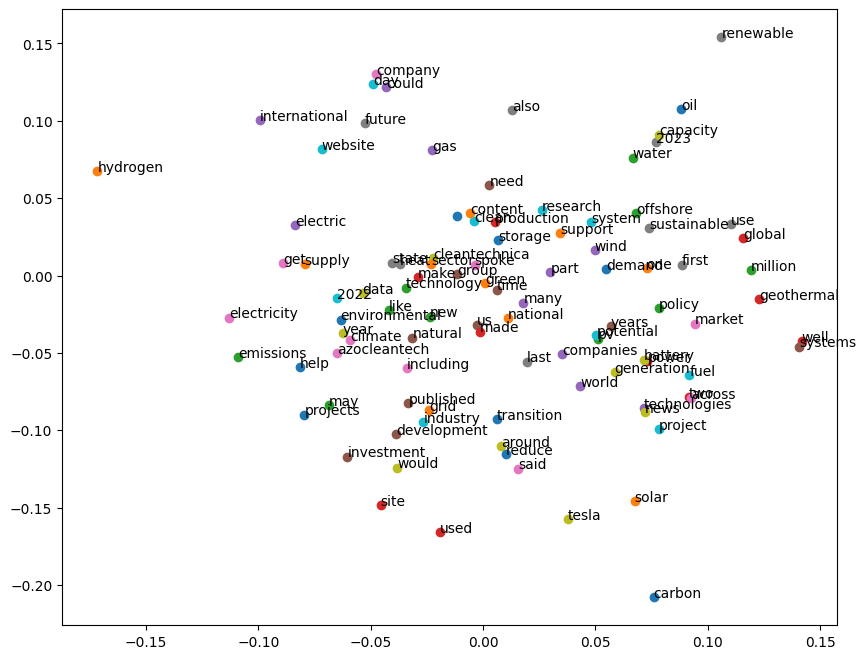

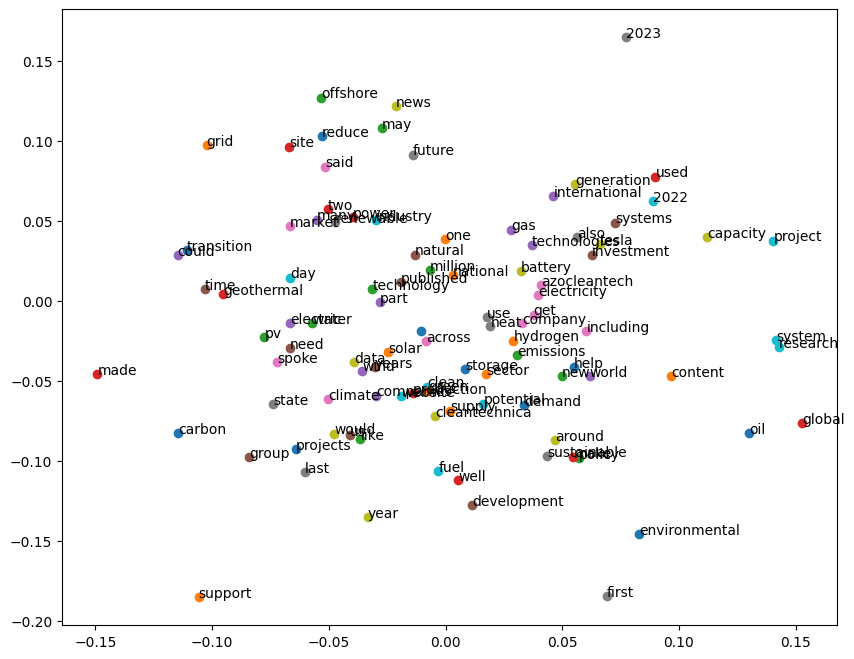

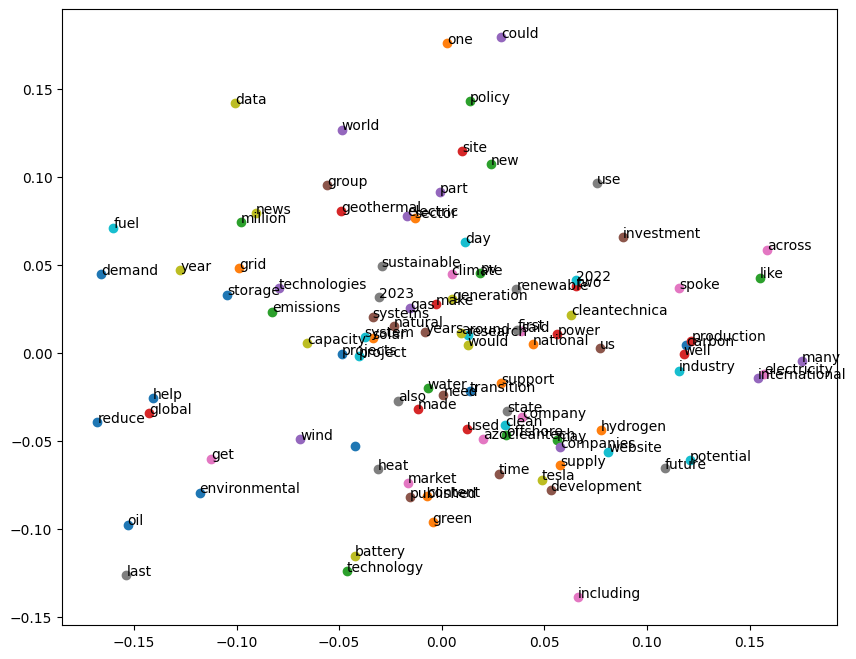

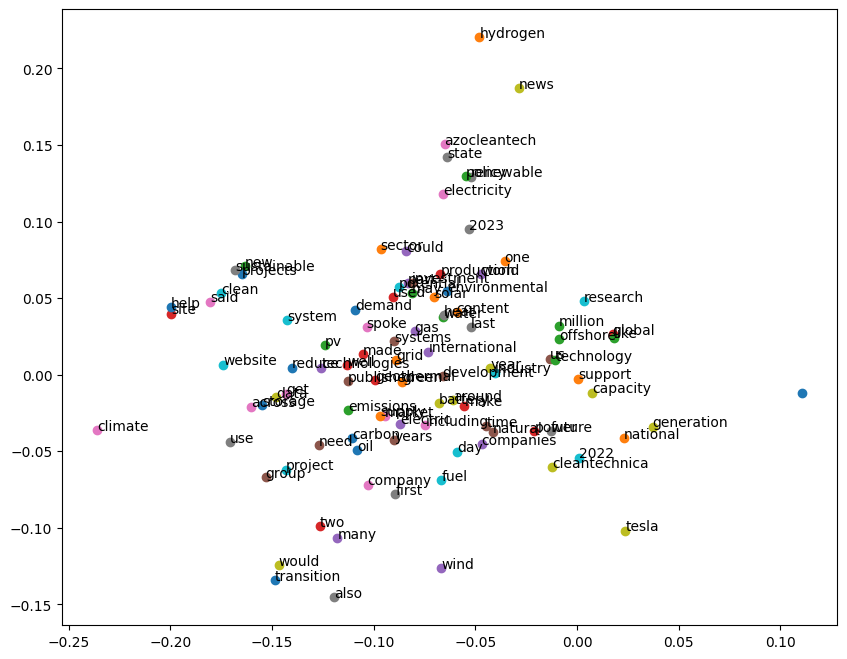

In [ ]:

for result in training_results:
  word_embeddings_2d = PCA(n_components=2).fit_transform(result['word_embeddings'])

  words_to_visualize = result['vocab_sample'][:100]

  plt.figure(figsize=(10, 8))
  for word in words_to_visualize:
      idx = result['vocab_sample'].index(word)
      emb = word_embeddings_2d[idx]
      plt.scatter(emb[0], emb[1])
      plt.text(emb[0], emb[1], word)

  plt.show()

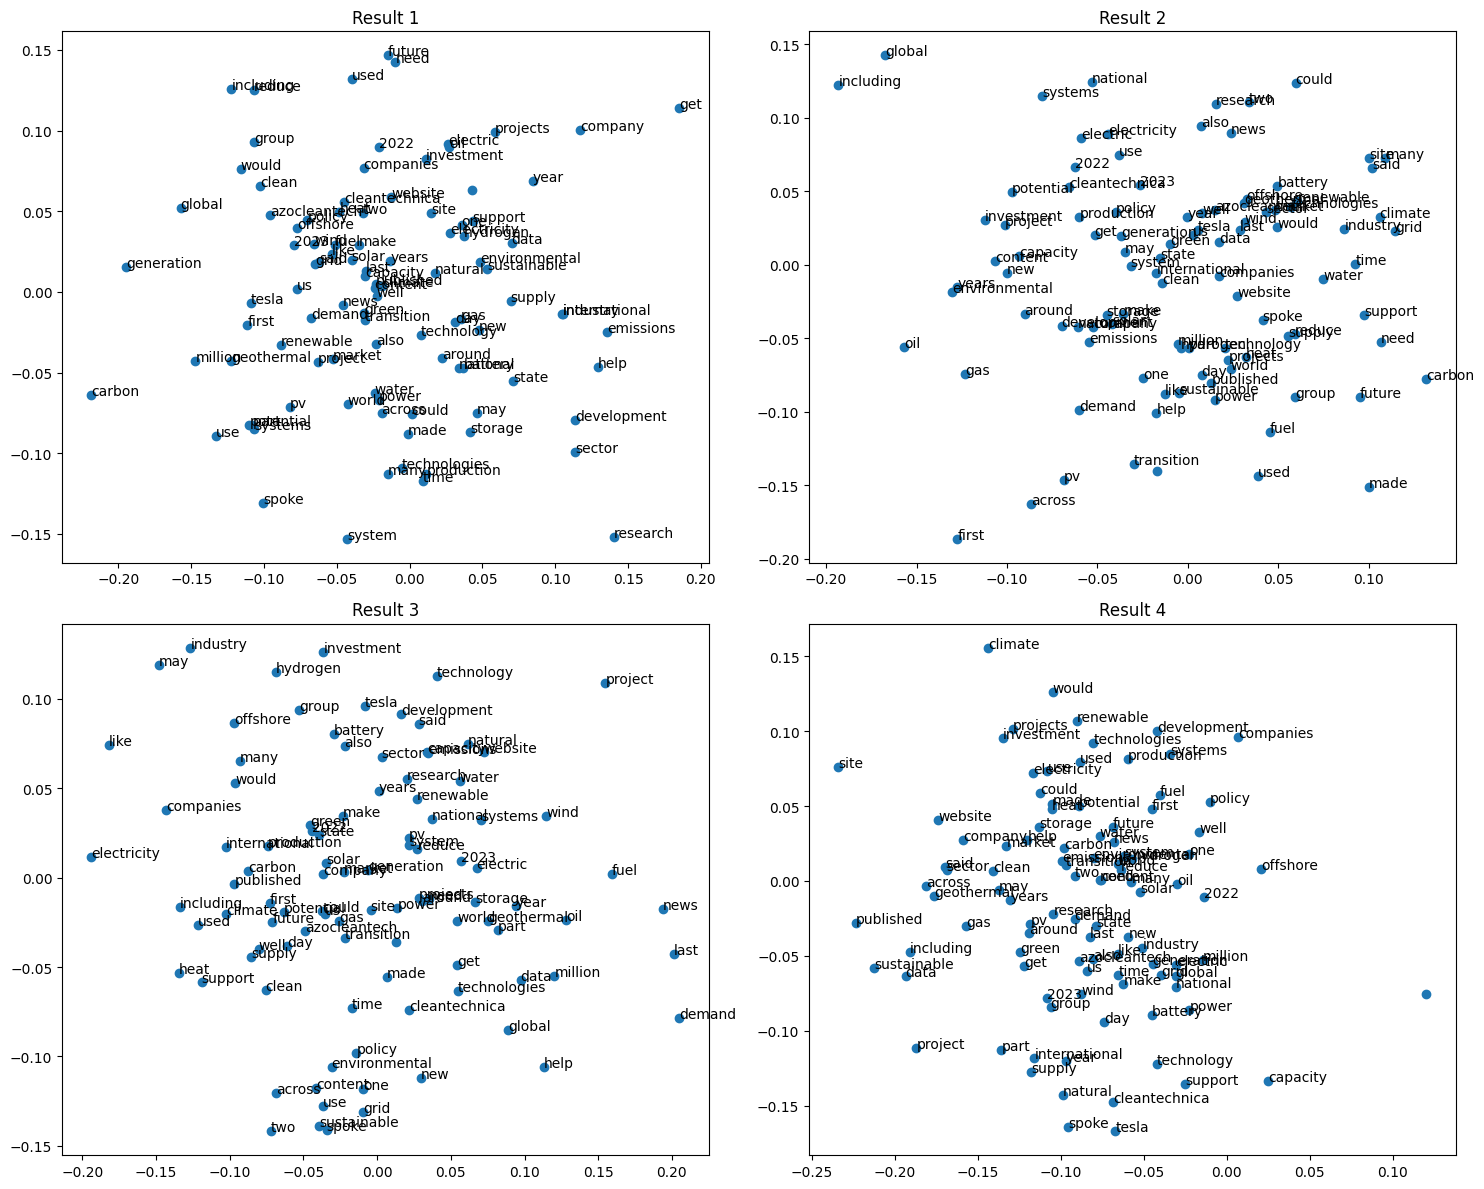

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming you have 'training_results' defined

# Determine the layout of subplots
num_results = len(training_results)
num_rows = min(2, int(num_results**0.5))
num_cols = (num_results + num_rows - 1) // num_rows

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Convert axs to a flat list for iteration
axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

for i, result in enumerate(training_results):
    word_embeddings_2d = PCA(n_components=2).fit_transform(result['word_embeddings'])

    words_to_visualize = result['vocab_sample'][:100]

    axs[i].scatter(word_embeddings_2d[:100, 0], word_embeddings_2d[:100, 1])
    axs[i].set_title(f"Result {i + 1}")
    for j, word in enumerate(words_to_visualize[:250]):
        idx = result['vocab_sample'].index(word)
        emb = word_embeddings_2d[idx]
        axs[i].text(emb[0], emb[1], word)

plt.tight_layout()
plt.show()

Our observations from training the four models are as follows:

*    Result 2 experienced an increase in the number of neighboring words, leading to a notable rise in training time and memory usage. Initially, we attempted with 8 words, but this caused a memory outage, even when using Google Colab Pro's High RAM T4 setting.

*    For Result 3, we raised the frequency threshold, selecting only words used more than 100 times in our vocabulary. This decision resulted in a shorter training time, but there is a potential downside of losing important words from our vocabulary and embedding set.

*    The number of epochs appears to have a significant impact on the quality of word embeddings. In the plot for Result 4, after 3 epochs (compared to the other models with only 1 training epoch), we observed a substantial improvement in clustering words more closely based on their semantic meanings.

### 3.4 Pretrained Word2Vec Model

In conclusion, we employ a pre-trained model to compute cosine similarity for the same four test words: 'agriculture,' 'energies,' 'solar,' and 'project,' just as we did with our in-house, self-built models.


In [ ]:
# Tokenize and remove stopwords from the sentences
tokenized_corpus = [word_tokenize(preprocess_text(sentence.lower())) for sentence in docsA]

# we set the same parameters as in the base_params in the inhouse model for better comparison

vector_size = 250 # EMBED_DIM
window = 4        # SKIPGRAM_N_WORDS
min_count = 50    # MIN_FREQ


# Define and train the Word2Vec model
pretrained_model = Word2Vec(sentences=tokenized_corpus, vector_size=vector_size, window=window, min_count=min_count, workers=4)


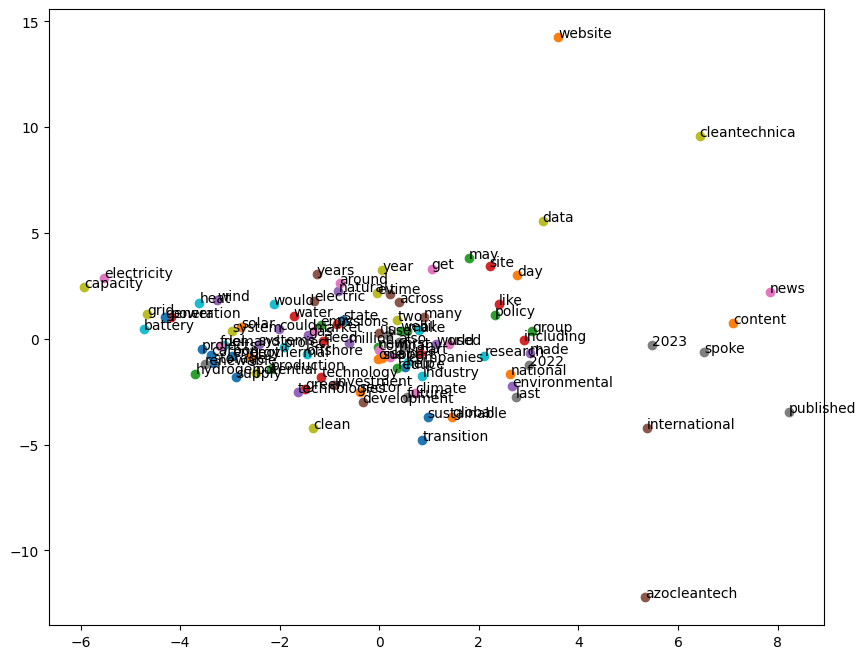

In [ ]:
# visualize vocabulary and embeddings:

# Get the vocabulary and word embeddings from the pretrained model
pretrained_vocab = list(pretrained_model.wv.index_to_key)
pretrained_word_embeddings = pretrained_model.wv[pretrained_vocab]

# Limit the number of words to visualize
num_words_to_visualize =100
pretrained_vocab_subset = pretrained_vocab[:num_words_to_visualize]
pretrained_word_embeddings_subset = pretrained_word_embeddings[:num_words_to_visualize]

# Perform PCA on word embeddings
pretrained_word_embeddings_2d = PCA(n_components=2).fit_transform(pretrained_word_embeddings_subset)

# Visualize word embeddings using scatter plot
plt.figure(figsize=(10, 8))
for word, emb in zip(pretrained_vocab, pretrained_word_embeddings_2d):
    plt.scatter(emb[0], emb[1])
    plt.text(emb[0], emb[1], word)

plt.show()

### 3.5 Pretrained and In-house Model Evaluation and Comparison

Upon comparing the scatterplots of the pretrained and in-house-built models, a notable observation emerges. The prebuilt model exhibits certain clusters with similar words, a characteristic not immediately apparent in the in-house model.

However, it's essential to acknowledge that achieving similar performance with the in-house model demands an extended training time, involving multiple epochs. Unfortunately, constrained by time and limited computational resources, particularly RAM capacity, the in-house model might not attain the same level of performance as the pretrained Word2Vec model.



In [ ]:
# For comparison, we create  this function to get N most similar words and cosine similarities

def get_top_similar_words(pretrained_model, word, n):
    if word not in pretrained_model.wv:
        print(f"'{word}' is not in the vocabulary.")
        return

    word_vector = pretrained_model.wv[word].reshape(1, -1)
    all_words = [w for w in pretrained_model.wv.index_to_key if w != word]

    # Calculate cosine similarity for all words
    all_vectors = np.array([pretrained_model.wv[w] for w in all_words])
    similarities = cosine_similarity(word_vector, all_vectors).flatten()

    # Get indices of top N similar words
    top_indices = similarities.argsort()[-n:][::-1]

    # Create a dictionary of similar words and their cosine similarities
    similar_words = {all_words[i]: similarities[i] for i in top_indices}

    return similar_words

# Example: Get the top 5 similar words and their cosine similarities for test words
testwords = ['agriculture', 'energies', 'solar', 'project']
pretrained_results = {}

for word in testwords:
    result = get_top_similar_words(pretrained_model, word, 5)
    pretrained_results[word] = result
    print(f"Similar words for '{word}': {result}")

Similar words for 'agriculture': {'farming': 0.79085803, 'aquaculture': 0.7823248, 'agricultural': 0.76966685, 'forestry': 0.73607343, 'tourism': 0.66975605}
Similar words for 'energies': {'edp': 0.57820326, 'brookfield': 0.55320334, 'energy': 0.5420048, 'gamesa': 0.50658554, 'ge': 0.49856648}
Similar words for 'solar': {'photovoltaic': 0.5718184, 'rooftop': 0.4644348, 'distributed': 0.420181, 'utilityscale': 0.41808152, 'rooftops': 0.4097741}
Similar words for 'project': {'projects': 0.61450917, 'facility': 0.5309362, 'farm': 0.5244542, 'plant': 0.5066023, 'programme': 0.44971392}


In [ ]:
# Add pretrained model results to each training result
for result in training_results:
    result['pretrained_results'] = pretrained_results


In [ ]:
for result in training_results:
    print(f"Variant Name: {result['variant_name']}")
    print(f"Similar Words Results: {result['similar_words']}")
    print(f"Pretrained Results: {result['pretrained_results']}")
    print('\n')


Variant Name: base_params
Similar Words Results: {'agriculture': {'headquartered': 0.22516608, 'old': 0.2122011, 'controversial': 0.2103227, 'vpps': 0.20180702, 'plc': 0.19900104}, 'energies': {'lowemission': 0.21784851, 'attributes': 0.20451769, 'inputs': 0.19520466, 'egec': 0.1941315, 'marks': 0.19126797}, 'solar': {'islands': 0.20636396, 'principle': 0.20190084, 'contractors': 0.19700429, 'benefiting': 0.18993862, 'submit': 0.18951577}, 'project': {'drone': 0.20585978, 'reactions': 0.20395282, 'word': 0.1916312, 'spatial': 0.18633679, 'targeting': 0.18611756}}
Pretrained Results: {'agriculture': {'farming': 0.79085803, 'aquaculture': 0.7823248, 'agricultural': 0.76966685, 'forestry': 0.73607343, 'tourism': 0.66975605}, 'energies': {'edp': 0.57820326, 'brookfield': 0.55320334, 'energy': 0.5420048, 'gamesa': 0.50658554, 'ge': 0.49856648}, 'solar': {'photovoltaic': 0.5718184, 'rooftop': 0.4644348, 'distributed': 0.420181, 'utilityscale': 0.41808152, 'rooftops': 0.4097741}, 'project': {

In the above section, we conduct a comparison of test words and their five most similar words. When juxtaposing these results with the pretrained model, the semantic disparities such as the difference in the cosine similarity values become notably striking and evident.
